## NN Adv Assignment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# 현재 작업 디렉토리 확인
current_directory = os.getcwd()
print("Current directory:", current_directory) # /content

# 작업 디렉토리 내의 파일 목록 확인
# os.listdir(current_directory)

# 작업 디렉토리 변경
new_directory = os.chdir('/content/drive/MyDrive/Tobigs/regular_session')
current_directory = os.getcwd()
print('Current directory:', current_directory)

Current directory: /content
Current directory: /content/drive/MyDrive/Tobigs/regular_session


In [ ]:
train = pd.read_csv('./data/Train.csv')
test = pd.read_csv('./data/Test.csv')

In [ ]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train['label'].nunique()

10

In [ ]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

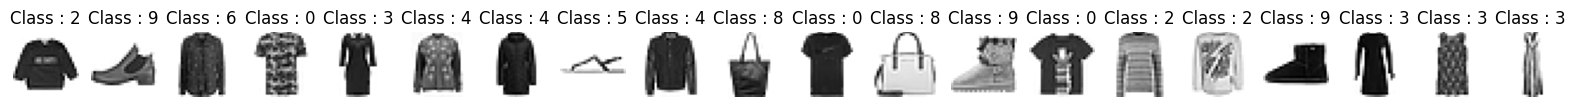

In [ ]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [ ]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

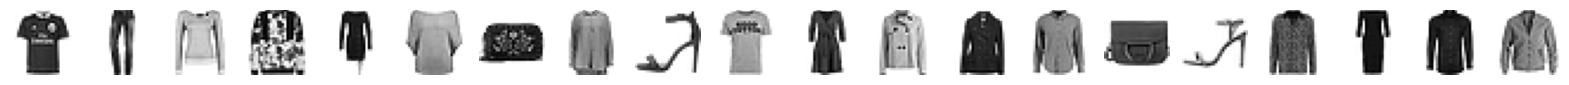

In [ ]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [ ]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cpu


In [ ]:
#Batch Size는 조정 가능합니다.
BATCH_SIZE = 128
#Epoch는 고정해주세요.
EPOCHS = 15

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [ ]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [ ]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()

  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

In [ ]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MyNet().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.02)
criterion = nn.CrossEntropyLoss()


[EPOCH: 1], 	Train Loss: 0.7514, 	Train Accuracy: 73.94 %, 	Val Loss: 0.4884, 	Val Accuracy: 83.16 % 

[EPOCH: 2], 	Train Loss: 0.4473, 	Train Accuracy: 83.94 %, 	Val Loss: 0.4265, 	Val Accuracy: 84.78 % 

[EPOCH: 3], 	Train Loss: 0.4049, 	Train Accuracy: 85.36 %, 	Val Loss: 0.3851, 	Val Accuracy: 86.04 % 

[EPOCH: 4], 	Train Loss: 0.3612, 	Train Accuracy: 86.79 %, 	Val Loss: 0.3892, 	Val Accuracy: 85.59 % 

[EPOCH: 5], 	Train Loss: 0.3409, 	Train Accuracy: 87.56 %, 	Val Loss: 0.3539, 	Val Accuracy: 86.97 % 

[EPOCH: 6], 	Train Loss: 0.3242, 	Train Accuracy: 88.10 %, 	Val Loss: 0.3449, 	Val Accuracy: 87.31 % 

[EPOCH: 7], 	Train Loss: 0.3094, 	Train Accuracy: 88.64 %, 	Val Loss: 0.3225, 	Val Accuracy: 88.27 % 

[EPOCH: 8], 	Train Loss: 0.2971, 	Train Accuracy: 89.17 %, 	Val Loss: 0.3224, 	Val Accuracy: 87.92 % 

[EPOCH: 9], 	Train Loss: 0.2853, 	Train Accuracy: 89.55 %, 	Val Loss: 0.3274, 	Val Accuracy: 87.64 % 

[EPOCH: 10], 	Train Loss: 0.2762, 	Train Accuracy: 89.75 %, 	Val Loss: 0.

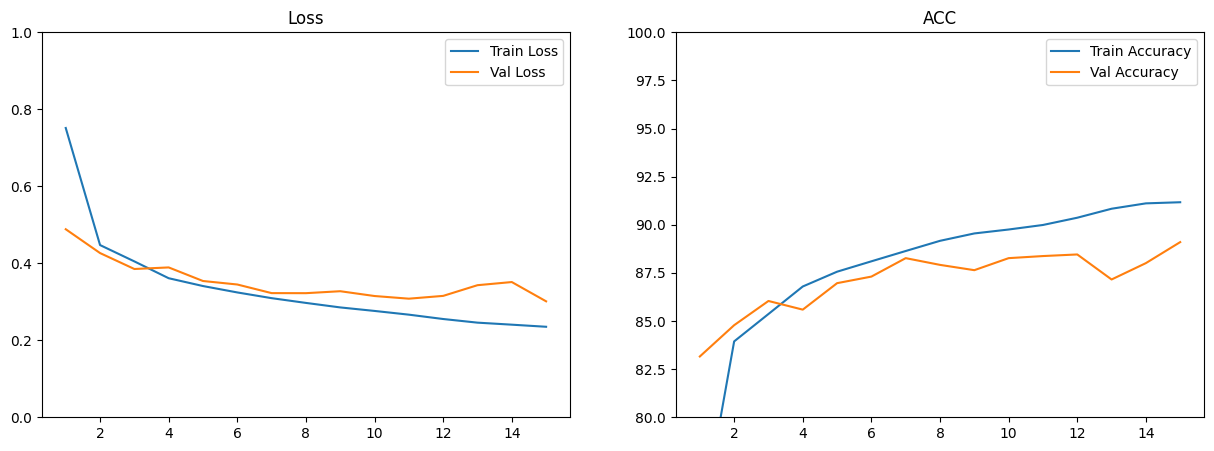

In [ ]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}

  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## 결론을 작성해주세요:


```markdown
- **Batch Size**: 128 (256으로 설정했을 때 초기 점수가 상대적으로 낮았습니다.)
- **Optimizer**: SGD, Momentum은 0.9로 설정 (Momentum을 0으로 설정했을 때보다 성능이 향상되었습니다.)
- **Loss Function**: CrossEntropyLoss
- **Learning Rate**: 0.02 (0.02 이상으로 설정하면 검증 점수가 불안정해지는 것을 관찰했습니다.)

15 epoch 동안 학습을 진행한 결과, 최종 검증 점수는 89.10을 달성했습니다. 반면에, 훈련 정확도는 91.17로, 과적합이 발생했습니다.
```